In [1]:
# Stock Price Prediction - Feature Analysis for RNN Sequence Selection
# Analyzing features to determine optimal sequence length for LSTM/GRU models
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10

print("="*80)
print("STOCK PRICE PREDICTION - FEATURE ANALYSIS")
print("="*80)
print("\nObjective: Determine optimal sequence length for RNN input")
print("Target: Predict if close price > current price after 30 trading days")
print("="*80)

STOCK PRICE PREDICTION - FEATURE ANALYSIS

Objective: Determine optimal sequence length for RNN input
Target: Predict if close price > current price after 30 trading days


In [2]:

# ============================================================================
# SECTION 1: DATA LOADING AND INITIAL PREPROCESSING
# ============================================================================

print("\n[1] LOADING DATA...")
# Load the dataset
df = pd.read_csv('../data/interim/train_clean_after_2010_and_bad_tickers.csv')

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])
df = df[df['open'] != 0]

# Sort by ticker and date
df = df.sort_values(['ticker', 'date']).reset_index(drop=True)

print(f"Total records: {len(df):,}")
print(f"Unique tickers: {df['ticker'].nunique():,}")
print(f"date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display basic statistics
print("\n" + "="*80)
print("DATA OVERVIEW")
print("="*80)
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())


[1] LOADING DATA...
Total records: 12,269,060
Unique tickers: 4,925
date range: 2010-01-04 00:00:00 to 2024-09-23 00:00:00

Memory usage: 1446.99 MB

DATA OVERVIEW
     ticker       date       open       high        low      close     volume  \
0  ticker_1 2010-01-04  27.875437  28.009543  27.570655  27.662090  2142300.0   
1  ticker_1 2010-01-05  27.729151  27.814489  27.131774  27.302454  2856000.0   
2  ticker_1 2010-01-06  27.278065  27.729145  27.278065  27.595039  2035400.0   
3  ticker_1 2010-01-07  27.637703  27.643798  27.375590  27.497503  1993400.0   
4  ticker_1 2010-01-08  27.424356  27.613320  27.253676  27.582842  1306400.0   

   dividends  stock_splits  
0        0.0           0.0  
1        0.0           0.0  
2        0.0           0.0  
3        0.0           0.0  
4        0.0           0.0  

Data types:
ticker                  object
date            datetime64[ns]
open                   float64
high                   float64
low                    float64
close 

In [3]:
# ============================================================================
# SECTION 2: FEATURE ENGINEERING
# ============================================================================
print("\n" + "="*80)
print("[2] ENGINEERING FEATURES...")
print("="*80)

def engineer_features(df):
    """
    Engineer features and keep only selected high-quality features
    in the order they were originally created.
    """
    df = df.copy()
    df = df.sort_values(['ticker', 'date']).reset_index(drop=True)
    grouped = df.groupby('ticker')

    # ------------------------------
    # Price Features
    # ------------------------------
    df['daily_return'] = grouped['close'].pct_change()
    df['high_low_ratio'] = (df['high'] - df['low']) / df['close']

    # ------------------------------
    # Moving Averages
    # ------------------------------
    df['MA_5'] = grouped['close'].transform(lambda x: x.rolling(5, min_periods=1).mean())
    df['MA_20'] = grouped['close'].transform(lambda x: x.rolling(20, min_periods=1).mean())
    df['MA_60'] = grouped['close'].transform(lambda x: x.rolling(60, min_periods=1).mean())

    # ------------------------------
    # MA-Based Features
    # ------------------------------
    df['price_to_MA5'] = (df['close'] - df['MA_5']) / (df['MA_5'] + 1e-8)
    df['price_to_MA20'] = (df['close'] - df['MA_20']) / (df['MA_20'] + 1e-8)
    df['price_to_MA60'] = (df['close'] - df['MA_60']) / (df['MA_60'] + 1e-8)
    df['MA_60_slope'] = grouped['MA_60'].pct_change(30)

    # ------------------------------
    # Volatility Features
    # ------------------------------
    df['volatility_20'] = grouped['daily_return'].transform(
        lambda x: x.rolling(20, min_periods=1).std()
    )

    def calculate_rsi(series, period=14):
        delta = series.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period, min_periods=1).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period, min_periods=1).mean()
        rs = gain / (loss + 1e-8)
        return 100 - (100 / (1 + rs))

    df['RSI_14'] = grouped['close'].transform(lambda x: calculate_rsi(x, 14))

    df['parkinson_volatility'] = grouped.apply(
        lambda x: np.sqrt(
            1/(4*np.log(2)) *
            ((np.log(x['high']/(x['low']+1e-8)))**2).rolling(10, min_periods=1).mean()
        )
    ).reset_index(level=0, drop=True)

    # ------------------------------
    # Support/Resistance & Risk
    # ------------------------------
    df['recent_high_20'] = grouped['high'].transform(lambda x: x.rolling(20, min_periods=1).max())
    df['recent_low_20'] = grouped['low'].transform(lambda x: x.rolling(20, min_periods=1).min())
    df['distance_from_high'] = (df['close'] - df['recent_high_20']) / (df['recent_high_20'] + 1e-8)
    df['low_to_close_ratio'] = df['recent_low_20'] / (df['close'] + 1e-8)
    df['price_position_20'] = (
        (df['close'] - df['recent_low_20']) /
        (df['recent_high_20'] - df['recent_low_20'] + 1e-8)
    )

    def max_drawdown(series, window):
        roll_max = series.rolling(window, min_periods=1).max()
        drawdown = (series - roll_max) / (roll_max + 1e-8)
        return drawdown.rolling(window, min_periods=1).min()

    df['max_drawdown_20'] = grouped['close'].transform(lambda x: max_drawdown(x, 20))
    df['downside_deviation_10'] = grouped['daily_return'].transform(
        lambda x: x.where(x < 0, 0).rolling(10, min_periods=1).std()
    )

    # ------------------------------
    # Temporal
    # ------------------------------
    df['month_sin'] = np.sin(2 * np.pi * df['date'].dt.month / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['date'].dt.month / 12)
    df['is_up_day'] = (df['daily_return'] > 0).astype(int)

    # ------------------------------
    # Volume Price Index (NEW)
    # ------------------------------
    df['price_change'] = grouped['close'].pct_change()
    df['PVT'] = (df['price_change'] * df['volume']).fillna(0)
    df['PVT_cumsum'] = grouped['PVT'].transform(lambda x: x.cumsum())

    df['MOBV_signal'] = np.where(df['price_change'] > 0, df['volume'],
                                  np.where(df['price_change'] < 0, -df['volume'], 0))
    df['MOBV'] = grouped['MOBV_signal'].transform(lambda x: x.cumsum())

    # ------------------------------
    # Directional Movement
    # ------------------------------
    df['MTM'] = df['close'] - grouped['close'].shift(12)

    # ------------------------------
    # OverBought & OverSold
    # ------------------------------
    df['DTM'] = np.where(df['open'] <= grouped['open'].shift(1),
                         0,
                         np.maximum(df['high'] - df['open'], df['open'] - grouped['open'].shift(1)))
    df['DBM'] = np.where(df['open'] >= grouped['open'].shift(1),
                         0,
                         np.maximum(df['open'] - df['low'], df['open'] - grouped['open'].shift(1)))
    df['DTM_sum'] = grouped['DTM'].transform(lambda x: x.rolling(23, min_periods=1).sum())
    df['DBM_sum'] = grouped['DBM'].transform(lambda x: x.rolling(23, min_periods=1).sum())
    df['ADTM'] = (df['DTM_sum'] - df['DBM_sum']) / (df['DTM_sum'] + df['DBM_sum'] + 1e-8)

    # ------------------------------
    # Energy & Volatility
    # ------------------------------
    df['PSY'] = grouped['is_up_day'].transform(lambda x: x.rolling(12, min_periods=1).mean()) * 100

    df['highest_close'] = grouped['close'].transform(lambda x: x.rolling(28, min_periods=1).max())
    df['lowest_close'] = grouped['close'].transform(lambda x: x.rolling(28, min_periods=1).min())
    df['close_diff_sum'] = grouped['close'].transform(lambda x: x.diff().abs().rolling(28, min_periods=1).sum())
    df['VHF'] = (df['highest_close'] - df['lowest_close']) / (df['close_diff_sum'] + 1e-8)

    # ------------------------------
    # Stochastic
    # ------------------------------
    df['lowest_low_9'] = grouped['low'].transform(lambda x: x.rolling(9, min_periods=1).min())
    df['highest_high_9'] = grouped['high'].transform(lambda x: x.rolling(9, min_periods=1).max())
    df['K'] = ((df['close'] - df['lowest_low_9']) / (df['highest_high_9'] - df['lowest_low_9'] + 1e-8)) * 100

    # ------------------------------
    # Cleanup temporary columns 41 - 16 = 26
    # ------------------------------
    temp_cols = [
        'MA_5', 'MA_20', 'MA_60',
        'price_change', 'PVT', 'MOBV_signal',
        'DTM', 'DBM', 'DTM_sum', 'DBM_sum',
        'highest_close', 'lowest_close', 'close_diff_sum',
        'lowest_low_9', 'highest_high_9', 'recent_low_20',
    ]
    df = df.drop(columns=temp_cols, errors='ignore')
    # df = df[ ['ticker', 'date'] + feature_columns_order ]

    return df


# Apply feature engineering
df_features = engineer_features(df)

print("\n✓ Feature engineering complete!")
print(f"Total features created: 25")
print(f"Rows with complete features: {df_features.dropna().shape[0]:,}")


[2] ENGINEERING FEATURES...

✓ Feature engineering complete!
Total features created: 25
Rows with complete features: 12,121,310


In [5]:
df_features.describe()

,date,open,high,low,close,volume,dividends,stock_splits,daily_return,high_low_ratio,...,month_sin,month_cos,is_up_day,PVT_cumsum,MOBV,MTM,ADTM,PSY,VHF,K
count,12269060,1.226906e+07,1.226906e+07,1.226906e+07,1.226906e+07,1.226906e+07,1.226906e+07,12269060.0,1.226414e+07,1.226906e+07,...,1.226906e+07,1.226906e+07,1.226906e+07,1.226906e+07,1.226906e+07,1.220996e+07,1.226414e+07,1.226906e+07,1.226414e+07,1.226906e+07
mean,2018-06-22 03:35:03.740627200,3.074913e+01,3.119991e+01,3.028538e+01,3.074179e+01,1.330067e+06,1.955660e-03,inf,6.663312e-04,3.531842e-02,...,-4.252390e-03,-2.625651e-02,4.916289e-01,7.364432e+06,5.156853e+07,5.910726e-02,2.393304e-01,4.911103e+01,3.348365e-01,5.139039e+01
min,2010-01-04 00:00:00,5.000000e-03,7.900000e-02,0.000000e+00,7.851000e-02,1.000000e+00,0.000000e+00,0.0,-9.750000e-01,0.000000e+00,...,-1.000000e+00,-1.000000e+00,0.000000e+00,-3.776399e+08,-7.958665e+09,-4.004200e+02,-1.000000e+00,0.000000e+00,0.000000e+00,-3.552714e-05
25%,2015-01-12 00:00:00,8.467739e+00,8.610000e+00,8.311608e+00,8.460069e+00,4.680000e+04,0.000000e+00,0.0,-1.079935e-02,1.464916e-02,...,-8.660254e-01,-8.660254e-01,0.000000e+00,-1.006962e+05,-1.372550e+04,-5.800009e-01,3.004312e-02,4.166667e+01,2.521738e-01,2.461514e+01
50%,2019-01-24 00:00:00,1.779000e+01,1.806000e+01,1.750000e+01,1.778005e+01,2.160000e+05,0.000000e+00,0.0,0.000000e+00,2.506059e-02,...,1.224647e-16,-1.836970e-16,0.000000e+00,6.261621e+04,5.192800e+06,3.502047e-02,2.541956e-01,5.000000e+01,3.159500e-01,5.212130e+01
75%,2022-03-04 00:00:00,3.649776e+01,3.703356e+01,3.593565e+01,3.649000e+01,8.792000e+05,0.000000e+00,0.0,1.092947e-02,4.332391e-02,...,5.000000e-01,5.000000e-01,1.000000e+00,1.145349e+06,3.336300e+07,7.437210e-01,4.624827e-01,5.833333e+01,3.978131e-01,7.853494e+01
max,2024-09-23 00:00:00,8.319200e+02,1.010080e+03,4.298801e+02,4.333400e+02,1.123003e+09,1.037500e+02,inf,2.573333e+02,1.048571e+01,...,1.000000e+00,1.000000e+00,1.000000e+00,4.411416e+09,2.102035e+10,3.858000e+02,1.000000e+00,1.000000e+02,1.000000e+00,1.138889e+02
std,NaN,3.890897e+01,3.944320e+01,3.836145e+01,3.889877e+01,5.651583e+06,5.997299e-02,NaN,8.726612e-02,4.018260e-02,...,7.093265e-01,7.043781e-01,4.999299e-01,7.580017e+07,2.903180e+08,4.304235e+00,3.097472e-01,1.456826e+01,1.136762e-01,3.014927e+01


In [6]:

missing_summary = (
    df_features.isna()
      .sum()
      .to_frame(name='missing_count')
      .assign(missing_pct=lambda x: x['missing_count'] / len(df) * 100)
      .sort_values('missing_count', ascending=False)
      .reset_index(names='column')
)

print(missing_summary)

                   column  missing_count  missing_pct
0             MA_60_slope         147750     1.204249
1                     MTM          59100     0.481699
2           volatility_20           9850     0.080283
3                    ADTM           4925     0.040142
4                     VHF           4925     0.040142
5            daily_return           4925     0.040142
6   downside_deviation_10           4925     0.040142
7                  ticker              0     0.000000
8                    date              0     0.000000
9                    open              0     0.000000
10           stock_splits              0     0.000000
11              dividends              0     0.000000
12         high_low_ratio              0     0.000000
13           price_to_MA5              0     0.000000
14                  close              0     0.000000
15                 volume              0     0.000000
16                    low              0     0.000000
17                   high   

In [9]:

# ============================================================================
# SECTION 3: DATA QUALITY ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("[3] DATA QUALITY ANALYSIS")
print("="*80)
# ============================================================
feature_columns = [
    # Price Features (3)
    'daily_return',
    'high_low_ratio',

    # MA-Based (4)
    'price_to_MA5',
    'price_to_MA20',
    'price_to_MA60',
    'MA_60_slope',

    # Volatility (3)
    'volatility_20',
    'RSI_14',
    'parkinson_volatility',

    # Critical Features (4)
    'recent_high_20',
    'distance_from_high',
    'low_to_close_ratio',
    'price_position_20',
    'max_drawdown_20',
    'downside_deviation_10',

    # Temporal (3)
    'month_sin',
    'month_cos',
    'is_up_day',

    # Volume Price Index (3) - Highest MI!
    'PVT_cumsum',           # MI = 0.0426 ⭐⭐⭐
    'MOBV',                 # MI = 0.0209 ⭐⭐

    # Directional Movement (4)
    'MTM',                  # MI = 0.0127 ⭐

    # OverBought & OverSold (1)
    'ADTM',                 # MI = 0.0104

    # Energy & Volatility (2)
    'PSY',                  # MI = 0.0085
    'VHF',                  # MI = 0.0088

    # Stochastic (1)
    'K',                    # MI = 0.0083

    # Raw Features

]

# Check missing values
print("\nMissing values in engineered features:")
missing_stats = df_features[feature_columns].isnull().sum()
missing_pct = (missing_stats / len(df_features) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing_Count': missing_stats,
    'Missing_Percentage': missing_pct
})
print(missing_df)

# Basic statistics
print("\n" + "="*80)
print("FEATURE STATISTICS")
print("="*80)
print(df_features[feature_columns].describe())

IMAGE_DIR = "Images2"
os.makedirs(IMAGE_DIR, exist_ok=True)

# Visualization: Distribution of features
for feature in feature_columns:
    data = df_features[feature].dropna()

    # Remove extreme outliers for better visualization (keep 1st-99th percentile)
    q1, q99 = data.quantile([0.01, 0.99])
    data_filtered = data[(data >= q1) & (data <= q99)]

    plt.figure(figsize=(12, 5))  # wider figure
    plt.hist(data_filtered, bins=100, edgecolor='black', alpha=0.7)
    plt.title(f'{feature} Distribution\n(1st-99th percentile)', fontsize=14)
    plt.xlabel('Value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(
        os.path.join(IMAGE_DIR, f'feature_{feature}.png'),
        dpi=300,
        bbox_inches='tight'
    )

    plt.show()


[3] DATA QUALITY ANALYSIS

Missing values in engineered features:


KeyboardInterrupt: 

In [8]:

# ============================================================================
# SECTION 4: AUTOCORRELATION ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("[4] AUTOCORRELATION ANALYSIS")
print("="*80)
print("Analyzing how each feature correlates with its past values")
print("This helps determine optimal sequence length for RNN")

# ----------------------------------------------------------------------------
# CONFIGURATION
# ----------------------------------------------------------------------------
NUM_TICKERS_TO_USE = 200    # <<< CHANGE THIS TO CONTROL HOW MANY TICKERS ARE USED
max_lags = 60             # Analyze up to 60 days lag
threshold = 0.05

# ----------------------------------------------------------------------------
# PREPARE DATA (KEEP TEMPORAL ORDER)
# ----------------------------------------------------------------------------
df_features = df_features.sort_values(['ticker', 'date'])

selected_tickers = (
    df_features['ticker']
    .dropna()
    .unique()[:NUM_TICKERS_TO_USE]
)

df_sample = (
    df_features
    .loc[df_features['ticker'].isin(selected_tickers)]
    .dropna(subset=feature_columns)
)

# ----------------------------------------------------------------------------
# AUTOCORRELATION COMPUTATION
# ----------------------------------------------------------------------------
autocorr_results = {}
# feature_columns = [
#     'daily_return', 'high_low_ratio', 'return_30',
#     #'MA_5', 'MA_10', 'MA_30', 'STD_10',
#     'log_volume', 'volume_ratio'
#     #, 'dividend_yield'
# ]

for feature in feature_columns:
    print(f"\nAnalyzing autocorrelation: {feature}")

    per_ticker_acfs = []

    for ticker, g in df_sample.groupby('ticker'):
        data = g[feature].dropna()

        if len(data) <= max_lags:
            continue

        autocorr_values = acf(data, nlags=max_lags, fft=True)
        per_ticker_acfs.append(autocorr_values)

    if len(per_ticker_acfs) == 0:
        print("  Not enough data")
        continue

    # Aggregate across tickers (median preserves typical temporal behavior)
    autocorr_values = np.median(per_ticker_acfs, axis=0)
    autocorr_results[feature] = autocorr_values

    # ----------------------------------------------------------------------------
    # PLOT (single plot per feature)
    # ----------------------------------------------------------------------------
    plt.figure(figsize=(8, 5))
    lags = np.arange(len(autocorr_values))

    plt.bar(lags, autocorr_values, width=0.8, alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    plt.axhline(y=threshold, color='red', linestyle='--', linewidth=1, label='Threshold (0.05)')
    plt.axhline(y=-threshold, color='red', linestyle='--', linewidth=1)

    plt.title(f'Autocorrelation: {feature}', fontsize=11, fontweight='bold')
    plt.xlabel('Lag (days)')
    plt.ylabel('Autocorrelation')
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(IMAGE_DIR, f'autocorrelation_{feature}.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # ----------------------------------------------------------------------------
    # FIND OPTIMAL LAG
    # ----------------------------------------------------------------------------
    significant_lags = np.where(np.abs(autocorr_values) > threshold)[0]

    if len(significant_lags) > 1:
        optimal_lag = significant_lags[-1]
        print(f"  Optimal lag: {optimal_lag} days (autocorr = {autocorr_values[optimal_lag]:.4f})")
    else:
        print(f"  low autocorrelation (independent)")

# ----------------------------------------------------------------------------
# SUMMARY TABLE OF AUTOCORRELATION DECAY
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("AUTOCORRELATION DECAY SUMMARY")
print("="*80)

decay_summary = []

for feature, autocorr_vals in autocorr_results.items():
    below_threshold = np.where(np.abs(autocorr_vals[1:]) < threshold)[0]

    if len(below_threshold) > 0:
        decay_lag = below_threshold[0] + 1
    else:
        decay_lag = max_lags

    decay_summary.append({
        'Feature': feature,
        'Lag_10': autocorr_vals[10],
        'Lag_20': autocorr_vals[20],
        'Lag_30': autocorr_vals[30],
        'Decay_Point': decay_lag
    })

decay_df = pd.DataFrame(decay_summary)
print(decay_df.to_string(index=False))



[4] AUTOCORRELATION ANALYSIS
Analyzing how each feature correlates with its past values
This helps determine optimal sequence length for RNN



KeyboardInterrupt



In [ ]:
# ============================================================================
# SECTION 5: TARGET-LAG CORRELATION ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("[5] TARGET-LAG CORRELATION ANALYSIS")
print("="*80)
print("Analyzing correlation between lagged features and target variable")

# ----------------------------------------------------------------------------
# CONFIGURATION
# ----------------------------------------------------------------------------
NUM_TICKERS_TO_USE = 50  # <<< CHANGE THIS TO CONTROL HOW MANY TICKERS ARE USED
max_lags = 60            # Should match SECTION 4 for consistency
PLOTS_PER_FIGURE = 12    # Number of subplots per figure (4x3 grid)

# ----------------------------------------------------------------------------
# PREPARE DATA (KEEP TEMPORAL ORDER)
# ----------------------------------------------------------------------------
df_features = df_features.sort_values(['ticker', 'date'])

selected_tickers = df_features['ticker'].dropna().unique()[:NUM_TICKERS_TO_USE]
df_sample = df_features.loc[df_features['ticker'].isin(selected_tickers)].copy()

# ----------------------------------------------------------------------------
# TARGET-LAG CORRELATION COMPUTATION
# ----------------------------------------------------------------------------
target_lag_results = {}

# Calculate how many figures we need
num_features = len(feature_columns)
num_figures = int(np.ceil(num_features / PLOTS_PER_FIGURE))

print(f"\nTotal features: {num_features}")
print(f"Plots per figure: {PLOTS_PER_FIGURE}")
print(f"Number of figures to create: {num_figures}")

# Initialize first figure
fig_idx = 0
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()
plot_idx_in_figure = 0

for feature_idx, feature in enumerate(feature_columns):
    print(f"\nAnalyzing target correlation: {feature} ({feature_idx+1}/{num_features})")

    correlations_per_lag = []

    # For each lag
    for lag in range(1, max_lags + 1):

        # Compute correlation per ticker
        per_ticker_corrs = []

        for ticker, g in df_sample.groupby('ticker'):
            ticker_data = g.sort_values('date').reset_index(drop=True)
            lagged_feature = ticker_data[feature].shift(lag)
            valid_mask = ticker_data['target'].notna() & lagged_feature.notna()

            if valid_mask.sum() > 30:  # Need at least 30 samples
                corr = ticker_data.loc[valid_mask, 'target'].corr(lagged_feature[valid_mask])
                per_ticker_corrs.append(corr)

        # Aggregate across tickers (median is robust)
        if len(per_ticker_corrs) > 0:
            correlations_per_lag.append(np.median(per_ticker_corrs))
        else:
            correlations_per_lag.append(0)

    target_lag_results[feature] = correlations_per_lag

    # ----------------------------------------------------------------------------
    # PLOT
    # ----------------------------------------------------------------------------
    axes[plot_idx_in_figure].plot(range(1, max_lags + 1), correlations_per_lag,
                   marker='o', markersize=3, linewidth=1.5)
    axes[plot_idx_in_figure].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    axes[plot_idx_in_figure].axhline(y=0.05, color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[plot_idx_in_figure].axhline(y=-0.05, color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[plot_idx_in_figure].set_title(f'Target Correlation: {feature}', fontsize=11, fontweight='bold')
    axes[plot_idx_in_figure].set_xlabel('Lag (days)')
    axes[plot_idx_in_figure].set_ylabel('Correlation with Target')
    axes[plot_idx_in_figure].grid(True, alpha=0.3)

    # ----------------------------------------------------------------------------
    # FIND PEAK CORRELATION
    # ----------------------------------------------------------------------------
    max_corr_idx = np.argmax(np.abs(correlations_per_lag))
    max_corr = correlations_per_lag[max_corr_idx]
    print(f"  Peak correlation: {max_corr:.4f} at lag {max_corr_idx + 1}")

    plot_idx_in_figure += 1

    # Check if we need to save current figure and start a new one
    if plot_idx_in_figure == PLOTS_PER_FIGURE or feature_idx == num_features - 1:
        # Hide any unused subplots in the current figure
        for unused_idx in range(plot_idx_in_figure, PLOTS_PER_FIGURE):
            axes[unused_idx].remove()

        plt.tight_layout()
        filename = f'03_target_lag_correlation_part{fig_idx+1}.png'
        plt.savefig(os.path.join(IMAGE_DIR, filename), dpi=300, bbox_inches='tight')
        print(f"\n✓ Saved: {filename}")
        plt.show()

        # Start new figure if there are more features to plot
        if feature_idx < num_features - 1:
            fig_idx += 1
            fig, axes = plt.subplots(4, 3, figsize=(18, 16))
            axes = axes.flatten()
            plot_idx_in_figure = 0

print("\n" + "="*80)
print(f"✓ Analysis complete! Created {fig_idx + 1} figure(s)")
print("="*80)

In [ ]:
# ============================================================================
# SECTION 6: TARGET-LAG MUTUAL INFORMATION ANALYSIS
# ============================================================================

from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler

print("\n" + "="*80)
print("[6] TARGET-LAG MUTUAL INFORMATION ANALYSIS")
print("="*80)
print("Analyzing mutual information between lagged features and binary target")

# ----------------------------------------------------------------------------
# CONFIGURATION
# ----------------------------------------------------------------------------
NUM_TICKERS_TO_USE = 50  # <<< CHANGE THIS TO CONTROL HOW MANY TICKERS ARE USED
max_lags = 60            # Should match previous sections for consistency
PLOTS_PER_FIGURE = 12    # Number of subplots per figure (4x3 grid)

# ----------------------------------------------------------------------------
# PREPARE DATA (KEEP TEMPORAL ORDER)
# ----------------------------------------------------------------------------
df_features = df_features.sort_values(['ticker', 'date'])

selected_tickers = df_features['ticker'].dropna().unique()[:NUM_TICKERS_TO_USE]
df_sample = df_features.loc[df_features['ticker'].isin(selected_tickers)].copy()

# ----------------------------------------------------------------------------
# TARGET-LAG MUTUAL INFORMATION COMPUTATION
# ----------------------------------------------------------------------------
target_mi_results = {}

# Calculate how many figures we need
num_features = len(feature_columns)
num_figures = int(np.ceil(num_features / PLOTS_PER_FIGURE))

print(f"\nTotal features: {num_features}")
print(f"Plots per figure: {PLOTS_PER_FIGURE}")
print(f"Number of figures to create: {num_figures}")

# Initialize first figure
fig_idx = 0
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()
plot_idx_in_figure = 0

for feature_idx, feature in enumerate(feature_columns):
    print(f"\nAnalyzing MI with target: {feature} ({feature_idx+1}/{num_features})")

    mi_scores_per_lag = []

    # For each lag
    for lag in range(1, max_lags + 1):

        # Compute MI per ticker
        per_ticker_mi = []

        for ticker, g in df_sample.groupby('ticker'):
            ticker_data = g.sort_values('date').reset_index(drop=True)
            lagged_feature = ticker_data[feature].shift(lag)
            valid_mask = ticker_data['target'].notna() & lagged_feature.notna()

            if valid_mask.sum() > 30:  # Need sufficient samples per ticker
                X_lag = lagged_feature[valid_mask].values.reshape(-1, 1)
                y_lag = ticker_data.loc[valid_mask, 'target'].values

                # Calculate MI for this ticker
                mi = mutual_info_classif(X_lag, y_lag,
                                        discrete_features=False,
                                        n_neighbors=3,
                                        random_state=42)[0]
                per_ticker_mi.append(mi)

        # Aggregate across tickers (median is robust)
        if len(per_ticker_mi) > 0:
            mi_scores_per_lag.append(np.median(per_ticker_mi))
        else:
            mi_scores_per_lag.append(0)

    target_mi_results[feature] = mi_scores_per_lag

    # ----------------------------------------------------------------------------
    # PLOT
    # ----------------------------------------------------------------------------
    axes[plot_idx_in_figure].plot(range(1, max_lags + 1), mi_scores_per_lag,
                   marker='o', markersize=3, linewidth=1.5, color='darkblue')
    axes[plot_idx_in_figure].axhline(y=0, color='black', linestyle='-', linewidth=0.8)

    # Add threshold line (optional - 0.01 is a reasonable baseline)
    axes[plot_idx_in_figure].axhline(y=0.01, color='red', linestyle='--',
                     linewidth=1, alpha=0.5, label='Threshold')

    axes[plot_idx_in_figure].set_title(f'Mutual Information: {feature}',
                       fontsize=11, fontweight='bold')
    axes[plot_idx_in_figure].set_xlabel('Lag (days)')
    axes[plot_idx_in_figure].set_ylabel('MI Score')
    axes[plot_idx_in_figure].grid(True, alpha=0.3)
    axes[plot_idx_in_figure].set_ylim(bottom=0)  # MI is always non-negative

    # ----------------------------------------------------------------------------
    # FIND PEAK MI
    # ----------------------------------------------------------------------------
    max_mi_idx = np.argmax(mi_scores_per_lag)
    max_mi = mi_scores_per_lag[max_mi_idx]
    print(f"  Peak MI: {max_mi:.4f} at lag {max_mi_idx + 1}")

    plot_idx_in_figure += 1

    # Check if we need to save current figure and start a new one
    if plot_idx_in_figure == PLOTS_PER_FIGURE or feature_idx == num_features - 1:
        # Hide any unused subplots in the current figure
        for unused_idx in range(plot_idx_in_figure, PLOTS_PER_FIGURE):
            axes[unused_idx].remove()

        plt.tight_layout()
        filename = f'04_target_lag_mutual_information_part{fig_idx+1}.png'
        plt.savefig(os.path.join(IMAGE_DIR, filename), dpi=300, bbox_inches='tight')
        print(f"\n✓ Saved: {filename}")
        plt.show()

        # Start new figure if there are more features to plot
        if feature_idx < num_features - 1:
            fig_idx += 1
            fig, axes = plt.subplots(4, 3, figsize=(18, 16))
            axes = axes.flatten()
            plot_idx_in_figure = 0

print("\n" + "="*80)
print(f"✓ Mutual Information analysis complete! Created {fig_idx + 1} figure(s)")
print("="*80)

# ============================================================================
# OPTIONAL: COMPARISON PLOT - CORRELATION vs MUTUAL INFORMATION
# ============================================================================

print("\n" + "="*80)
print("BONUS: CORRELATION vs MUTUAL INFORMATION COMPARISON")
print("="*80)

# Create comparison plot for top features by MI (select top 12)
# Sort features by max MI score
feature_max_mi = {feat: max(target_mi_results[feat])
                  for feat in feature_columns if feat in target_mi_results}
top_features = sorted(feature_max_mi.items(), key=lambda x: x[1], reverse=True)[:12]
comparison_features = [feat for feat, _ in top_features]

# Calculate number of comparison figures needed
num_comp_plots = len(comparison_features)
num_comp_figures = int(np.ceil(num_comp_plots / PLOTS_PER_FIGURE))

for comp_fig_idx in range(num_comp_figures):
    start_idx = comp_fig_idx * PLOTS_PER_FIGURE
    end_idx = min(start_idx + PLOTS_PER_FIGURE, num_comp_plots)
    features_in_figure = comparison_features[start_idx:end_idx]

    fig, axes = plt.subplots(4, 3, figsize=(18, 16))
    axes = axes.flatten()

    for idx, feature in enumerate(features_in_figure):
        if feature in target_lag_results and feature in target_mi_results:

            # Create twin axis
            ax1 = axes[idx]
            ax2 = ax1.twinx()

            # Plot correlation
            lags = range(1, max_lags + 1)
            line1 = ax1.plot(lags, target_lag_results[feature],
                            color='blue', marker='o', markersize=2,
                            linewidth=1.5, label='Correlation', alpha=0.7)
            ax1.axhline(y=0, color='blue', linestyle='-', linewidth=0.8, alpha=0.3)
            ax1.set_xlabel('Lag (days)', fontsize=10)
            ax1.set_ylabel('Correlation', color='blue', fontsize=10)
            ax1.tick_params(axis='y', labelcolor='blue')

            # Plot MI
            line2 = ax2.plot(lags, target_mi_results[feature],
                            color='red', marker='s', markersize=2,
                            linewidth=1.5, label='Mutual Information', alpha=0.7)
            ax2.set_ylabel('Mutual Information', color='red', fontsize=10)
            ax2.tick_params(axis='y', labelcolor='red')
            ax2.set_ylim(bottom=0)

            # Title and legend
            ax1.set_title(f'{feature}: Correlation vs MI',
                         fontsize=12, fontweight='bold')
            ax1.grid(True, alpha=0.3)

            # Combined legend
            lines = line1 + line2
            labels = [l.get_label() for l in lines]
            ax1.legend(lines, labels, loc='upper left', fontsize=9)

    # Hide unused subplots
    for unused_idx in range(len(features_in_figure), PLOTS_PER_FIGURE):
        axes[unused_idx].remove()

    plt.tight_layout()
    filename = f'05_correlation_vs_MI_comparison_part{comp_fig_idx+1}.png'
    plt.savefig(os.path.join(IMAGE_DIR, filename), dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved: {filename}")
    plt.show()

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================

print("\n" + "="*80)
print("SUMMARY: TOP PREDICTIVE LAGS")
print("="*80)

summary_data = []

for feature in feature_columns:
    if feature in target_lag_results and feature in target_mi_results:

        # Best correlation
        corr_values = target_lag_results[feature]
        best_corr_idx = np.argmax(np.abs(corr_values))
        best_corr = corr_values[best_corr_idx]

        # Best MI
        mi_values = target_mi_results[feature]
        best_mi_idx = np.argmax(mi_values)
        best_mi = mi_values[best_mi_idx]

        summary_data.append({
            'Feature': feature,
            'Best_Corr': best_corr,
            'Best_Corr_Lag': best_corr_idx + 1,
            'Best_MI': best_mi,
            'Best_MI_Lag': best_mi_idx + 1
        })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Best_MI', ascending=False)

print("\nTop Features by Mutual Information:")
print(summary_df.head(20).to_string(index=False))  # Show top 20
print(f"\n... and {len(summary_df) - 20} more features")

# Save summary
summary_df.to_csv('target_lag_analysis_summary.csv', index=False)
print("\n✓ Saved: target_lag_analysis_summary.csv")

In [ ]:
# ============================================================================
# SECTION 7: ROLLING STATISTICS ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("[7] ROLLING STATISTICS ANALYSIS")
print("="*80)
print("Analyzing stability of features across different window sizes")

# ----------------------------------------------------------------------------
# CONFIGURATION
# ----------------------------------------------------------------------------
NUM_TICKERS_TO_USE = 50   # <<< CHANGE THIS TO CONTROL HOW MANY TICKERS TO INCLUDE
windows = [5, 10, 15, 20, 30, 45, 60]
PLOTS_PER_FIGURE = 12     # Number of subplots per figure (4x3 grid)

# ----------------------------------------------------------------------------
# PREPARE DATA
# ----------------------------------------------------------------------------
df_features = df_features.sort_values(['ticker', 'date'])
selected_tickers = df_features['ticker'].dropna().unique()[:NUM_TICKERS_TO_USE]
df_sample = df_features.loc[df_features['ticker'].isin(selected_tickers)].copy()

# ----------------------------------------------------------------------------
# CALCULATE ROLLING STATISTICS
# ----------------------------------------------------------------------------
rolling_stats_results = {feature: {'windows': [], 'mean_std': [], 'std_std': []}
                         for feature in feature_columns}

# Calculate how many figures we need
num_features = len(feature_columns)
num_figures = int(np.ceil(num_features / PLOTS_PER_FIGURE))

print(f"\nTotal features: {num_features}")
print(f"Plots per figure: {PLOTS_PER_FIGURE}")
print(f"Number of figures to create: {num_figures}")

for feature_idx, feature in enumerate(feature_columns):
    print(f"Analyzing rolling stats: {feature} ({feature_idx+1}/{num_features})")

    for window in windows:

        per_ticker_mean_std = []
        per_ticker_std_std = []

        for ticker, g in df_sample.groupby('ticker'):
            ticker_data = g.sort_values('date').reset_index(drop=True)
            rolling_mean = ticker_data[feature].rolling(window=window).mean()
            rolling_std = ticker_data[feature].rolling(window=window).std()

            mean_stability = rolling_mean.std()
            std_stability = rolling_std.std()

            per_ticker_mean_std.append(mean_stability)
            per_ticker_std_std.append(std_stability)

        # Aggregate across tickers (median)
        rolling_stats_results[feature]['windows'].append(window)
        rolling_stats_results[feature]['mean_std'].append(np.median(per_ticker_mean_std))
        rolling_stats_results[feature]['std_std'].append(np.median(per_ticker_std_std))

# ----------------------------------------------------------------------------
# PLOT
# ----------------------------------------------------------------------------
# Initialize first figure
fig_idx = 0
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()
plot_idx_in_figure = 0

for feature_idx, feature in enumerate(feature_columns):
    ax = axes[plot_idx_in_figure]

    windows_list = rolling_stats_results[feature]['windows']
    mean_std_list = rolling_stats_results[feature]['mean_std']
    std_std_list = rolling_stats_results[feature]['std_std']

    ax2 = ax.twinx()

    line1 = ax.plot(windows_list, mean_std_list, 'b-o', label='Rolling Mean Std', linewidth=2)
    line2 = ax2.plot(windows_list, std_std_list, 'r-s', label='Rolling Std Std', linewidth=2)

    ax.set_xlabel('Window Size (days)')
    ax.set_ylabel('Std of Rolling Mean', color='b')
    ax2.set_ylabel('Std of Rolling Std', color='r')
    ax.set_title(f'Rolling Statistics: {feature}', fontsize=11, fontweight='bold')
    ax.tick_params(axis='y', labelcolor='b')
    ax2.tick_params(axis='y', labelcolor='r')
    ax.grid(True, alpha=0.3)

    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='upper right', fontsize=8)

    plot_idx_in_figure += 1

    # Check if we need to save current figure and start a new one
    if plot_idx_in_figure == PLOTS_PER_FIGURE or feature_idx == num_features - 1:
        # Hide any unused subplots in the current figure
        for unused_idx in range(plot_idx_in_figure, PLOTS_PER_FIGURE):
            axes[unused_idx].remove()

        plt.tight_layout()
        filename = f'06_rolling_statistics_part{fig_idx+1}.png'
        plt.savefig(os.path.join(IMAGE_DIR, filename), dpi=300, bbox_inches='tight')
        print(f"\n✓ Saved: {filename}")
        plt.show()

        # Start new figure if there are more features to plot
        if feature_idx < num_features - 1:
            fig_idx += 1
            fig, axes = plt.subplots(4, 3, figsize=(18, 16))
            axes = axes.flatten()
            plot_idx_in_figure = 0

print("\n" + "="*80)
print(f"✓ Rolling statistics analysis complete! Created {fig_idx + 1} figure(s)")
print("="*80)

# ============================================================================
# OPTIONAL: SUMMARY ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("SUMMARY: FEATURE STABILITY ACROSS WINDOWS")
print("="*80)

stability_summary = []

for feature in feature_columns:
    mean_std_values = rolling_stats_results[feature]['mean_std']
    std_std_values = rolling_stats_results[feature]['std_std']

    # Calculate stability metrics (lower is more stable)
    avg_mean_stability = np.mean(mean_std_values)
    avg_std_stability = np.mean(std_std_values)

    # Calculate how much stability changes across windows (consistency)
    mean_stability_variance = np.std(mean_std_values)
    std_stability_variance = np.std(std_std_values)

    stability_summary.append({
        'Feature': feature,
        'Avg_Mean_Stability': avg_mean_stability,
        'Avg_Std_Stability': avg_std_stability,
        'Mean_Stability_Variance': mean_stability_variance,
        'Std_Stability_Variance': std_stability_variance
    })

stability_df = pd.DataFrame(stability_summary)
stability_df = stability_df.sort_values('Avg_Mean_Stability')

print("\nMost Stable Features (by Rolling Mean):")
print(stability_df.head(15).to_string(index=False))

print("\n\nLeast Stable Features (by Rolling Mean):")
print(stability_df.tail(10).to_string(index=False))

# Save summary
stability_df.to_csv('rolling_statistics_summary.csv', index=False)
print("\n✓ Saved: rolling_statistics_summary.csv")

Using 4924 tickers
Computed correlations for 4924 tickers


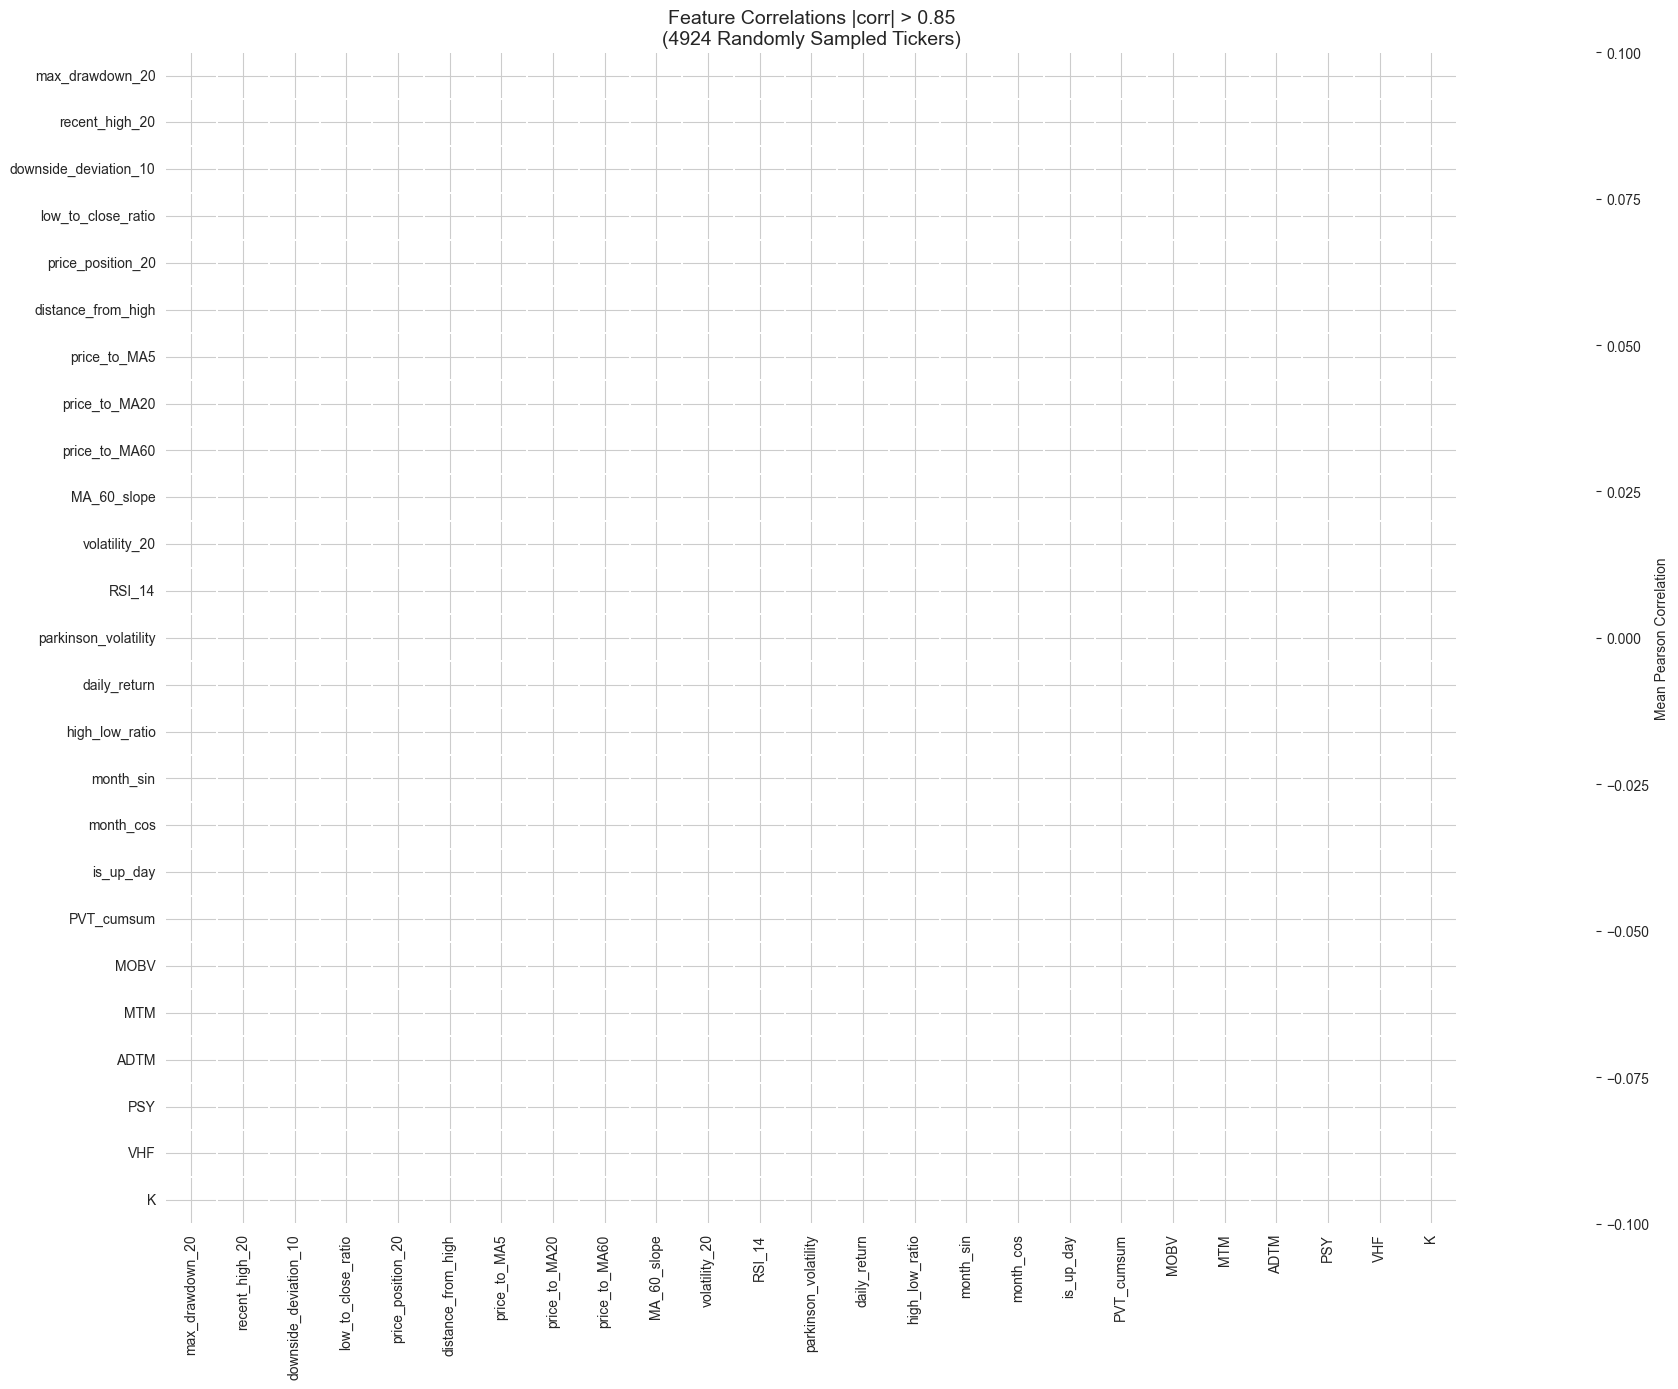

In [15]:
# ============================================================================
# SECTION 8: Correlation between features
# ============================================================================

# ============================================================
# CONFIG
# ============================================================
RANDOM_STATE = 42
N_TICKERS_SAMPLE = 5000
MIN_ROWS_PER_TICKER = 100
THRESHOLD = 0.85

# Mask correlations with absolute value <= threshold





# ============================================================
# SAMPLE TICKERS
feature_columns = [
    # ════════════════════════════════════════════════════════════════════════
    # PREVIOUSLY VALIDATED FEATURES (28 features)
    # ════════════════════════════════════════════════════════════════════════

    # Price Features (3)
    'daily_return',
    'high_low_ratio',

    # MA-Based (4)
    'price_to_MA5',
    'price_to_MA20',
    'price_to_MA60',
    'MA_60_slope',

    # Volatility (3)
    'volatility_20',
    'RSI_14',
    'parkinson_volatility',

    # Critical Features (4)
    'recent_high_20',
    'distance_from_high',
    'low_to_close_ratio',
    'price_position_20',
    'max_drawdown_20',
    'downside_deviation_10',

    # Temporal (3)
    'month_sin',
    'month_cos',
    'is_up_day',

    # Volume Price Index (3) - Highest MI!
    'PVT_cumsum',           # MI = 0.0426 ⭐⭐⭐
    'MOBV',                 # MI = 0.0209 ⭐⭐

    # Directional Movement (4)
    'MTM',                  # MI = 0.0127 ⭐

    # OverBought & OverSold (1)
    'ADTM',                 # MI = 0.0104

    # Energy & Volatility (2)
    'PSY',                  # MI = 0.0085
    'VHF',                  # MI = 0.0088

    # Stochastic (1)
    'K',                    # MI = 0.0083
]
# ============================================================
rng = np.random.default_rng(RANDOM_STATE)

valid_tickers = (
    df_features.groupby('ticker')
      .size()
      .loc[lambda x: x >= MIN_ROWS_PER_TICKER]
      .index
)

sample_tickers = rng.choice(
    valid_tickers,
    size=min(N_TICKERS_SAMPLE, len(valid_tickers)),
    replace=False
)
df_sample = df_features[df_features['ticker'].isin(sample_tickers)]

print(f"Using {df_sample['ticker'].nunique()} tickers")

# ============================================================
# PER-TICKER CORRELATION
# ============================================================
corr_matrices = []



for ticker, g in df_sample.groupby('ticker'):
    feature_df = g[feature_columns].dropna()

    if len(feature_df) < 30:
        continue

    corr = feature_df.corr(method='pearson')
    corr_matrices.append(corr.values)

corr_matrices = np.array(corr_matrices)

print(f"Computed correlations for {corr_matrices.shape[0]} tickers")

# ============================================================
# AGGREGATE (MEAN CORRELATION)
# ============================================================
mean_corr = np.nanmean(corr_matrices, axis=0)

mean_corr_df = pd.DataFrame(
    mean_corr,
    index=feature_columns,
    columns=feature_columns
)

mask = mean_corr_df.abs() <= THRESHOLD
np.fill_diagonal(mask.values, True)  # optional: hide diagonal

# ============================================================
# HEATMAP
# ============================================================
plt.figure(figsize=(18, 14))
sns.heatmap(
    mean_corr_df,
    mask=mask,
    cmap='coolwarm',
    center=0,
    linewidths=0.3,
    cbar_kws={'label': 'Mean Pearson Correlation'},
    annot=True,
    fmt=".2f"
)

plt.title(
    f"Feature Correlations |corr| > {THRESHOLD}\n"
    f"({len(sample_tickers)} Randomly Sampled Tickers)",
    fontsize=14
)

plt.tight_layout()
plt.show()
